# Model recovery attack: `drive-diagnosis`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mra
from mra import *

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

xy = np.loadtxt("../datasets/drive-diagnosis.txt")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]

min_values = np.array([min(x[:,i]) for i in range(x.shape[1])])
max_values = np.array([max(x[:,i]) for i in range(x.shape[1])])
x = (x-min_values)/(max_values - min_values)
y = y.reshape((len(x), 1)).astype("float32")-1
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

2022-02-13 18:02:57.306169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-13 18:02:57.306203: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-13 18:02:57.306570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    output = tf.keras.layers.Dense(256, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256, activation="relu")(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(11, activation="softmax")(x)
    return tf.keras.Model(xin, output)

In [4]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.sparse_categorical_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=1000
    )

Iteration 0001: Training loss: 2.3745
Iteration 1001: Training loss: 0.5666
Iteration 2001: Training loss: 0.1778
Iteration 3001: Training loss: 0.4151
Iteration 4001: Training loss: 0.3699
Iteration 5001: Training loss: 1.2730
Iteration 6001: Training loss: 0.1569
Iteration 7001: Training loss: 0.1423
Iteration 8001: Training loss: 0.2431
Iteration 9001: Training loss: 0.4517


In [5]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(1024, activation=act)(xin)
    x = tf.keras.layers.Dense(512, activation=act)(x)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(48, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [6]:
log_attack = mra.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.1816, RG-normal: 0.1563, reconstruction validation: 0.0529
Iteration 0002: RG-uniform: 0.1783, RG-normal: 0.1568, reconstruction validation: 0.0505
Iteration 0003: RG-uniform: 0.1767, RG-normal: 0.1633, reconstruction validation: 0.0537
Iteration 0004: RG-uniform: 0.1812, RG-normal: 0.1577, reconstruction validation: 0.0487
Iteration 0005: RG-uniform: 0.1806, RG-normal: 0.1622, reconstruction validation: 0.0510
Iteration 0006: RG-uniform: 0.1683, RG-normal: 0.1521, reconstruction validation: 0.0489
Iteration 0007: RG-uniform: 0.1787, RG-normal: 0.1584, reconstruction validation: 0.0531
Iteration 0008: RG-uniform: 0.1834, RG-normal: 0.1633, reconstruction validation: 0.0494
Iteration 0009: RG-uniform: 0.1765, RG-normal: 0.1560, reconstruction validation: 0.0473
Iteration 0010: RG-uniform: 0.1843, RG-normal: 0.1582, reconstruction validation: 0.0459
Iteration 0011: RG-uniform: 0.1706, RG-normal: 0.1549, reconstruction validation: 0.0506
Iteration 0012: RG-un

In [7]:
np.savetxt("./log/drive.csv", log_attack, delimiter=",")

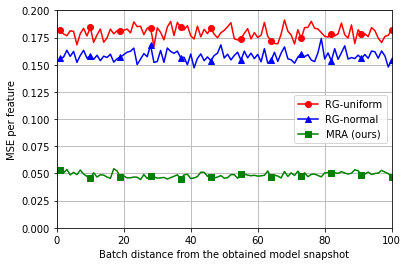

In [16]:
plt.xlim([0,100])
plt.ylim([0,0.2])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(ran, log_attack[:,0], 'ro-', ran, log_attack[:,1], 'b^-', ran, log_attack[:,2], 'gs-', markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA (ours)'], loc='center right')
plt.savefig("fig/drive.pdf", bbox_inches='tight')